In [35]:
# @title 1: Improved Setup for Better 10-Class Performance
# Install required packages
!pip install --upgrade mediapipe scikit-learn

# Core imports and setup
import os, gc, json, logging, warnings, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = "0"

# Set seeds for reproducibility
SEED = 42
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(SEED)

# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU setup complete: {len(gpus)} GPU(s)")
    except Exception as e:
        print(f"GPU setup warning: {e}")

# IMPROVED Configuration for better 10-class performance
class Config:
    def __init__(self):
        # Dataset paths
        possible_paths = [
            "/kaggle/input/wlasl-processed/",
            "/root/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5",
            "/root/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/4",
            "/content/wlasl-processed/",
        ]

        self.dataset_base_path = None
        for path in possible_paths:
            if os.path.exists(path):
                self.dataset_base_path = path
                break

        if self.dataset_base_path is None:
            self.dataset_base_path = "/kaggle/input/wlasl-processed/"

        # IMPROVED data strategy - more data per class
        self.target_classes = 10
        self.min_videos_per_class = 15          # Increased back to 15
        self.preferred_videos_per_class = 25    # More videos per class
        self.max_videos_per_class = 35          # Higher cap
        self.allow_class_imbalance = True
        self.max_imbalance_ratio = 2.0          # Stricter balance

        # LONGER sequences for more information
        self.sequence_length = 48               # Increased from 32
        self.batch_size = 8                     # Smaller batches for stability
        self.num_epochs = 150                   # More epochs
        self.learning_rate = 0.0001             # MUCH lower learning rate
        self.validation_split = 0.2             # Less validation, more training

        # LARGER model architecture - need capacity for 10 classes
        self.lstm1_units = 64                   # Increased capacity
        self.lstm2_units = 48
        self.lstm3_units = 32                   # Third LSTM layer
        self.dense1_units = 128                 # Much larger dense layers
        self.dense2_units = 96
        self.dense3_units = 64
        self.dense4_units = 32                  # Additional dense layer

        # BALANCED regularization - prevent overfitting but allow learning
        self.lstm_dropout = 0.25                # Reduced dropout for learning
        self.lstm_recurrent_dropout = 0.25
        self.dense_dropout_1 = 0.35
        self.dense_dropout_2 = 0.45
        self.dense_dropout_3 = 0.55
        self.dense_dropout_4 = 0.65
        self.l2_reg = 0.0005                    # Moderate L2
        self.label_smoothing = 0.05             # Light label smoothing

        # STRONGER loss function
        self.use_focal_loss = True
        self.focal_alpha = 0.25
        self.focal_gamma = 2.0                  # Back to stronger gamma
        self.min_detection_confidence = 0.3     # Lower for more data
        self.use_class_weights = True

        # BETTER training strategy
        self.early_stopping_patience = 25
        self.lr_reduction_patience = 12
        self.lr_reduction_factor = 0.5
        self.min_lr = 1e-7

        # ENHANCED data augmentation
        self.use_data_augmentation = True
        self.augmentation_probability = 0.6     # More aggressive augmentation
        self.gradient_clip_norm = 1.0

        # NEW: Progressive training strategy
        self.use_progressive_training = True
        self.warmup_epochs = 10
        self.plateau_threshold = 5

        self.model_name = f"improved_asl_{self.target_classes}_classes"

        print(f"IMPROVED CONFIGURATION FOR 10 CLASSES:")
        print(f"  Strategy: More data + Larger model + Better training")
        print(f"  Sequence length: {self.sequence_length} (increased)")
        print(f"  Model size: {self.lstm1_units}-{self.lstm2_units}-{self.lstm3_units} LSTM")
        print(f"  Dense layers: {self.dense1_units}-{self.dense2_units}-{self.dense3_units}-{self.dense4_units}")
        print(f"  Learning rate: {self.learning_rate} (much lower)")
        print(f"  Data per class: {self.min_videos_per_class}-{self.max_videos_per_class}")

# Create configuration instance
config = Config()
print("\nIMPROVED Configuration initialized!")
print("FOCUS: Fix 10-class performance with more data + larger model + careful training")

GPU setup complete: 1 GPU(s)
IMPROVED CONFIGURATION FOR 10 CLASSES:
  Strategy: More data + Larger model + Better training
  Sequence length: 48 (increased)
  Model size: 64-48-32 LSTM
  Dense layers: 128-96-64-32
  Learning rate: 0.0001 (much lower)
  Data per class: 15-35

IMPROVED Configuration initialized!
FOCUS: Fix 10-class performance with more data + larger model + careful training


In [36]:
# @title 2: Dataset Download
# Download dataset from Kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/wlasl-processed


In [37]:
# @title 3: Enhanced Feature Extraction for Better 10-Class Performance
import glob, cv2
import numpy as np
from scipy import ndimage

try:
    import mediapipe as mp
    MEDIAPIPE_AVAILABLE = True
    print("MediaPipe successfully imported")
except Exception as e:
    MEDIAPIPE_AVAILABLE = False
    print(f"MediaPipe not available: {e}")

class EnhancedFeatureExtractor:
    def __init__(self, min_confidence=0.3):
        self.total_features = 126  # 2 hands * 21 landmarks * 3 coordinates
        self.min_confidence = min_confidence

        if MEDIAPIPE_AVAILABLE:
            try:
                self.mp_hands = mp.solutions.hands
                self.hands = self.mp_hands.Hands(
                    static_image_mode=False,
                    max_num_hands=2,
                    model_complexity=1,  # Higher complexity for better detection
                    min_detection_confidence=self.min_confidence,
                    min_tracking_confidence=0.6
                )
                self.use_mediapipe = True
                print(f"Enhanced MediaPipe extractor ready (confidence={self.min_confidence})")
            except Exception as e:
                print(f"MediaPipe setup failed: {e}")
                self.use_mediapipe = False
        else:
            self.use_mediapipe = False

    def preprocess_frame(self, frame):
        """Enhanced frame preprocessing for better hand detection"""
        height, width = frame.shape[:2]

        # Resize to optimal detection size
        if height < 480 or width < 640:
            frame = cv2.resize(frame, (640, 480))
        elif height > 720 or width > 1280:
            frame = cv2.resize(frame, (1280, 720))

        # Enhanced preprocessing
        # 1. Contrast and brightness adjustment
        frame = cv2.convertScaleAbs(frame, alpha=1.15, beta=8)

        # 2. Noise reduction
        frame = cv2.bilateralFilter(frame, 9, 75, 75)

        # 3. Slight gaussian blur for stability
        frame = cv2.GaussianBlur(frame, (3, 3), 0)

        return frame

    def extract_features(self, frame):
        if not self.use_mediapipe:
            return np.zeros(self.total_features, dtype=np.float32)

        try:
            # Enhanced preprocessing
            frame = self.preprocess_frame(frame)
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = self.hands.process(rgb)

            features = np.zeros(self.total_features, dtype=np.float32)

            if results.multi_hand_landmarks and results.multi_handedness:
                # Better hand sorting for consistency
                hand_data = []
                for i, (hand_landmarks, handedness) in enumerate(zip(results.multi_hand_landmarks, results.multi_handedness)):
                    if i >= 2:
                        break

                    # More reliable hand identification
                    is_right_hand = handedness.classification[0].label == 'Right'
                    confidence = handedness.classification[0].score
                    center_x = np.mean([lm.x for lm in hand_landmarks.landmark])

                    hand_coords = []
                    for landmark in hand_landmarks.landmark:
                        # Normalize coordinates relative to hand center for better consistency
                        norm_x = landmark.x - center_x
                        hand_coords.extend([norm_x + center_x, landmark.y, landmark.z])

                    hand_data.append((is_right_hand, center_x, hand_coords, confidence))

                # Sort by confidence first, then handedness, then position
                hand_data.sort(key=lambda x: (-x[3], not x[0], x[1]))

                for i, (_, _, hand_coords, _) in enumerate(hand_data[:2]):
                    start_idx = i * 63
                    end_idx = start_idx + 63
                    features[start_idx:end_idx] = hand_coords

            return features

        except Exception as e:
            return np.zeros(self.total_features, dtype=np.float32)

def enhanced_data_augmentation(features, config):
    """More sophisticated data augmentation"""
    if np.random.random() > config.augmentation_probability:
        return features

    augmented = features.copy()

    # 1. Temporal augmentation - random frame drops
    if np.random.random() > 0.7:
        num_drops = max(1, int(len(features) * 0.05))  # Drop 5% of frames
        drop_indices = np.random.choice(len(features), num_drops, replace=False)

        for idx in drop_indices:
            if 0 < idx < len(features) - 1:
                # Interpolate dropped frames
                augmented[idx] = (augmented[idx-1] + augmented[idx+1]) / 2

    # 2. Spatial jittering with hand-aware noise
    if np.random.random() > 0.6:
        jitter_strength = 0.008
        for frame_idx in range(len(augmented)):
            for hand_idx in range(2):
                start_coord = hand_idx * 63
                hand_center_x = 0
                hand_center_y = 0
                valid_landmarks = 0

                # Calculate hand center
                for landmark_idx in range(21):
                    coord_start = start_coord + landmark_idx * 3
                    if augmented[frame_idx, coord_start] != 0:
                        hand_center_x += augmented[frame_idx, coord_start]
                        hand_center_y += augmented[frame_idx, coord_start + 1]
                        valid_landmarks += 1

                if valid_landmarks > 0:
                    hand_center_x /= valid_landmarks
                    hand_center_y /= valid_landmarks

                    # Apply coordinated jitter relative to hand center
                    jitter_x = np.random.normal(0, jitter_strength)
                    jitter_y = np.random.normal(0, jitter_strength)

                    for landmark_idx in range(21):
                        coord_start = start_coord + landmark_idx * 3
                        if augmented[frame_idx, coord_start] != 0:
                            augmented[frame_idx, coord_start] += jitter_x
                            augmented[frame_idx, coord_start + 1] += jitter_y

    # 3. Temporal smoothing variation
    if np.random.random() > 0.8:
        smoothing_strength = np.random.uniform(0.1, 0.3)
        for i in range(1, len(augmented) - 1):
            augmented[i] = (1 - smoothing_strength) * augmented[i] + \
                          smoothing_strength * 0.5 * (augmented[i-1] + augmented[i+1])

    return augmented

def extract_video_features_enhanced(video_path, sequence_length=48, min_confidence=0.3, config=None):
    """Enhanced feature extraction with better quality control"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    extractor = EnhancedFeatureExtractor(min_confidence=min_confidence)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 30

    # Better frame sampling strategy
    if total_frames > sequence_length * 3:
        # Sample more frames for better selection
        num_samples = min(sequence_length * 5, total_frames)
        frame_indices = np.linspace(0, total_frames-1, num_samples, dtype=int)
    else:
        # Use all available frames
        frame_indices = list(range(0, total_frames))

    valid_features = []
    quality_scores = []

    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            continue

        feat = extractor.extract_features(frame)

        # Enhanced quality scoring
        non_zero_count = np.count_nonzero(feat)
        non_zero_ratio = non_zero_count / feat.size

        if non_zero_ratio > 0.05:  # At least 5% non-zero
            feature_variance = np.var(feat[feat != 0]) if non_zero_count > 0 else 0
            feature_mean = np.mean(np.abs(feat[feat != 0])) if non_zero_count > 0 else 0

            # Multi-factor quality score
            quality_score = (
                non_zero_ratio * 0.4 +
                min(feature_variance * 2000, 1.0) * 0.3 +
                min(feature_mean * 50, 1.0) * 0.3
            )

            if feature_variance > 5e-7 and feature_mean > 1e-5:
                valid_features.append(feat)
                quality_scores.append(quality_score)

    cap.release()

    if len(valid_features) < 8:  # Need minimum frames
        return None

    # Select best frames with temporal distribution
    if len(valid_features) > sequence_length:
        # Sort by quality and take top candidates
        quality_indices = np.argsort(quality_scores)[-sequence_length*2:]

        # From top candidates, select with temporal distribution
        selected_features = [valid_features[i] for i in quality_indices]

        # Ensure temporal order
        if len(selected_features) > sequence_length:
            # Uniform sampling from high-quality frames
            indices = np.linspace(0, len(selected_features)-1, sequence_length, dtype=int)
            selected_features = [selected_features[i] for i in indices]
    else:
        selected_features = valid_features

    # Convert to array and ensure correct length
    features_array = np.array(selected_features, dtype=np.float32)

    if len(features_array) < sequence_length:
        # Better interpolation
        if len(features_array) == 1:
            features_array = np.tile(features_array, (sequence_length, 1))
        else:
            from scipy import interpolate
            original_indices = np.arange(len(features_array))
            target_indices = np.linspace(0, len(features_array)-1, sequence_length)

            interpolated = np.zeros((sequence_length, features_array.shape[1]))
            for feature_idx in range(features_array.shape[1]):
                f = interpolate.interp1d(original_indices, features_array[:, feature_idx],
                                       kind='linear', fill_value='extrapolate')
                interpolated[:, feature_idx] = f(target_indices)
            features_array = interpolated.astype(np.float32)

    elif len(features_array) > sequence_length:
        # Uniform sampling
        indices = np.linspace(0, len(features_array)-1, sequence_length, dtype=int)
        features_array = features_array[indices]

    # Apply advanced temporal smoothing
    if len(features_array) > 5:
        smoothed = np.copy(features_array)
        for i in range(2, len(features_array) - 2):
            # 5-point smoothing with weights
            weights = np.array([0.1, 0.25, 0.3, 0.25, 0.1])
            smoothed[i] = np.average(features_array[i-2:i+3], axis=0, weights=weights)
        features_array = smoothed

    return features_array

# Set the main function
extract_video_features = extract_video_features_enhanced

print("Enhanced feature extraction ready!")
print("IMPROVEMENTS:")
print("  - Better frame preprocessing")
print("  - Advanced quality scoring")
print("  - Sophisticated data augmentation")
print("  - Temporal smoothing and interpolation")
print("  - Hand-aware coordinate processing")

MediaPipe successfully imported
Enhanced feature extraction ready!
IMPROVEMENTS:
  - Better frame preprocessing
  - Advanced quality scoring
  - Sophisticated data augmentation
  - Temporal smoothing and interpolation
  - Hand-aware coordinate processing


In [43]:
# @title 4: Fixed Model Architecture (ENHANCED FOCAL LOSS DEFINED)
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout, BatchNormalization,
                                   LayerNormalization, GlobalAveragePooling1D, Add,
                                   MultiHeadAttention, SpatialDropout1D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import tensorflow.keras.backend as K

# FIXED: Define enhanced_focal_loss function globally
def enhanced_focal_loss(alpha=0.25, gamma=2.0):
    """Enhanced focal loss with better numerical stability"""
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Convert sparse labels to one-hot
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), tf.shape(y_pred)[-1])

        # Calculate cross entropy
        ce_loss = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred), axis=-1)

        # Calculate pt (probability of true class)
        pt = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)

        # Calculate focal weight
        focal_weight = alpha * tf.pow((1 - pt), gamma)

        # Apply focal weight
        focal_loss = focal_weight * ce_loss

        return focal_loss

    return focal_loss_fixed

# Also define the original focal_loss for backward compatibility
def focal_loss(alpha=0.25, gamma=2.0):
    """Standard focal loss function"""
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Convert sparse labels to one-hot
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), tf.shape(y_pred)[-1])

        # Calculate focal loss
        pt = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        alpha_t = alpha
        focal_weight = alpha_t * tf.pow((1 - pt), gamma)
        focal_loss = -focal_weight * tf.math.log(pt + epsilon)

        return focal_loss

    return focal_loss_fixed

def create_larger_model(config, num_classes):
    """Create larger model with sufficient capacity for multiple classes"""
    tf.keras.backend.clear_session()
    set_seeds(SEED)

    print(f"Building LARGER model for {num_classes} classes...")
    print(f"   INCREASED capacity to handle complexity")
    print(f"   LSTM: {config.lstm1_units}-{config.lstm2_units}-{config.lstm3_units}")
    print(f"   Dense: {config.dense1_units}-{config.dense2_units}-{config.dense3_units}-{config.dense4_units}")
    print(f"   Features: Attention + residual connections")

    inputs = Input(shape=(config.sequence_length, 126), dtype='float32', name='input')
    x = inputs

    # Input processing with feature transformation
    x = Dense(config.sequence_length * 2, activation='relu', name='input_transform')(x)
    x = LayerNormalization(name='input_norm')(x)
    x = SpatialDropout1D(0.1, name='input_dropout')(x)

    # Multi-head attention for better feature relationships
    attention_out = MultiHeadAttention(
        num_heads=4,
        key_dim=32,
        dropout=0.15,
        name='multi_head_attention'
    )(x, x)

    # Residual connection
    x = Add(name='attention_residual')([x, attention_out])
    x = LayerNormalization(name='attention_norm')(x)

    # LARGER LSTM sequence with residual connections
    # First LSTM block
    lstm1_out = LSTM(config.lstm1_units, return_sequences=True,
                     dropout=config.lstm_dropout,
                     recurrent_dropout=config.lstm_recurrent_dropout,
                     kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg),
                     recurrent_regularizer=tf.keras.regularizers.l2(config.l2_reg),
                     name='lstm1')(x)

    lstm1_out = LayerNormalization(name='lstm1_norm')(lstm1_out)
    lstm1_out = Dropout(0.2, name='lstm1_extra_dropout')(lstm1_out)

    # Second LSTM block
    lstm2_out = LSTM(config.lstm2_units, return_sequences=True,
                     dropout=config.lstm_dropout,
                     recurrent_dropout=config.lstm_recurrent_dropout,
                     kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg),
                     recurrent_regularizer=tf.keras.regularizers.l2(config.l2_reg),
                     name='lstm2')(lstm1_out)

    lstm2_out = LayerNormalization(name='lstm2_norm')(lstm2_out)
    lstm2_out = Dropout(0.2, name='lstm2_extra_dropout')(lstm2_out)

    # Third LSTM block
    lstm3_out = LSTM(config.lstm3_units, return_sequences=True,
                     dropout=config.lstm_dropout,
                     recurrent_dropout=config.lstm_recurrent_dropout,
                     kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg),
                     recurrent_regularizer=tf.keras.regularizers.l2(config.l2_reg),
                     name='lstm3')(lstm2_out)

    lstm3_out = LayerNormalization(name='lstm3_norm')(lstm3_out)

    # Global average pooling to capture temporal patterns
    x = GlobalAveragePooling1D(name='global_avg_pool')(lstm3_out)
    x = Dropout(0.25, name='post_pool_dropout')(x)

    # LARGER dense network for complex classification
    # First dense block
    x = Dense(config.dense1_units, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg),
              name='dense1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = Dropout(config.dense_dropout_1, name='dropout1')(x)

    # Second dense block
    x = Dense(config.dense2_units, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg),
              name='dense2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Dropout(config.dense_dropout_2, name='dropout2')(x)

    # Third dense block
    x = Dense(config.dense3_units, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg),
              name='dense3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Dropout(config.dense_dropout_3, name='dropout3')(x)

    # Fourth dense block - transition to output
    x = Dense(config.dense4_units, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg),
              name='dense4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Dropout(config.dense_dropout_4, name='dropout4')(x)

    # Output layer with no regularization to allow learning
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs, outputs, name=f'Large_ASL_Model_{num_classes}_classes')
    return model

def warmup_cosine_schedule(epoch, initial_lr=0.0001, warmup_epochs=10, total_epochs=150):
    """Learning rate schedule with warmup and cosine decay"""
    if epoch < warmup_epochs:
        # Linear warmup
        return initial_lr * (epoch + 1) / warmup_epochs
    else:
        # Cosine decay
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return initial_lr * 0.5 * (1 + np.cos(np.pi * progress))

def plot_detailed_results(history, model_name):
    """Detailed plotting for multi-class results"""
    try:
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))

        # Loss plot with smoothing
        train_loss = history.history['loss']
        val_loss = history.history.get('val_loss', [])

        axes[0,0].plot(train_loss, label='Training Loss', linewidth=2, alpha=0.7)
        if val_loss:
            axes[0,0].plot(val_loss, label='Validation Loss', linewidth=2)

        # Add trend lines
        if len(train_loss) > 10:
            z = np.polyfit(range(len(train_loss)), train_loss, 1)
            p = np.poly1d(z)
            axes[0,0].plot(range(len(train_loss)), p(range(len(train_loss))),
                          "r--", alpha=0.8, label='Train Trend')

        axes[0,0].set_title('Training Loss with Trends')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Accuracy plot
        train_acc = history.history['accuracy']
        val_acc = history.history.get('val_accuracy', [])

        axes[0,1].plot(train_acc, label='Training Accuracy', linewidth=2)
        if val_acc:
            axes[0,1].plot(val_acc, label='Validation Accuracy', linewidth=2)

            # Mark best validation accuracy
            best_val_idx = np.argmax(val_acc)
            best_val_acc = val_acc[best_val_idx]
            axes[0,1].plot(best_val_idx, best_val_acc, 'ro', markersize=8,
                          label=f'Best Val: {best_val_acc:.3f}')

        axes[0,1].set_title('Model Accuracy')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Learning rate schedule
        if 'lr' in history.history:
            lr_history = history.history['lr']
            axes[0,2].plot(lr_history, label='Learning Rate', linewidth=2, color='green')
            axes[0,2].set_title('Learning Rate Schedule')
            axes[0,2].set_xlabel('Epoch')
            axes[0,2].set_ylabel('Learning Rate')
            axes[0,2].set_yscale('log')
            axes[0,2].legend()
            axes[0,2].grid(True, alpha=0.3)

        # Overfitting analysis
        if val_loss and val_acc:
            loss_gap = np.array(val_loss) - np.array(train_loss[:len(val_loss)])
            acc_gap = np.array(train_acc[:len(val_acc)]) - np.array(val_acc)

            axes[1,0].plot(loss_gap, label='Validation - Training Loss', linewidth=2, color='red')
            axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[1,0].fill_between(range(len(loss_gap)), loss_gap, 0,
                                  where=(np.array(loss_gap) > 0), alpha=0.3, color='red',
                                  label='Overfitting Zone')
            axes[1,0].set_title('Overfitting Monitor (Loss Gap)')
            axes[1,0].set_xlabel('Epoch')
            axes[1,0].set_ylabel('Loss Difference')
            axes[1,0].legend()
            axes[1,0].grid(True, alpha=0.3)

            axes[1,1].plot(acc_gap, label='Training - Validation Acc', linewidth=2, color='orange')
            axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[1,1].fill_between(range(len(acc_gap)), acc_gap, 0,
                                  where=(np.array(acc_gap) > 0.1), alpha=0.3, color='orange',
                                  label='Significant Gap')
            axes[1,1].set_title('Accuracy Gap Analysis')
            axes[1,1].set_xlabel('Epoch')
            axes[1,1].set_ylabel('Accuracy Difference')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)

        # Performance progression
        if val_acc and len(val_acc) > 5:
            # Calculate moving average
            window = min(10, len(val_acc)//3)
            if window >= 3:
                moving_avg = np.convolve(val_acc, np.ones(window)/window, mode='valid')
                axes[1,2].plot(range(window-1, len(val_acc)), moving_avg,
                              label=f'Moving Avg (window={window})', linewidth=3, color='blue')

            axes[1,2].plot(val_acc, label='Raw Validation Accuracy', alpha=0.6, color='lightblue')
            axes[1,2].set_title('Validation Accuracy Progression')
            axes[1,2].set_xlabel('Epoch')
            axes[1,2].set_ylabel('Accuracy')
            axes[1,2].legend()
            axes[1,2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Detailed analysis
        if val_acc and train_acc:
            best_val_acc = max(val_acc)
            best_epoch = np.argmax(val_acc) + 1
            final_train_acc = train_acc[-1]
            final_val_acc = val_acc[-1]
            final_gap = final_train_acc - final_val_acc

            print(f"\nDETAILED MULTI-CLASS ANALYSIS:")
            print(f"Best validation accuracy: {best_val_acc:.4f} (epoch {best_epoch})")
            print(f"Final train/val accuracy: {final_train_acc:.4f}/{final_val_acc:.4f}")
            print(f"Final overfitting gap: {final_gap:.4f}")

            # Performance assessment for multiple classes
            num_classes = 10  # Default assumption
            if hasattr(history, 'model') and hasattr(history.model, 'layers'):
                for layer in history.model.layers:
                    if hasattr(layer, 'units') and layer.name == 'output':
                        num_classes = layer.units
                        break

            random_baseline = 1.0 / num_classes
            improvement = (best_val_acc - random_baseline) / random_baseline * 100

            print(f"Random baseline: {random_baseline:.1%}")
            print(f"Improvement over random: {improvement:.1f}%")

            if best_val_acc > 0.4:
                print("PERFORMANCE: EXCELLENT for multi-class problem")
            elif best_val_acc > 0.25:
                print("PERFORMANCE: GOOD for multi-class complexity")
            elif best_val_acc > 0.15:
                print("PERFORMANCE: REASONABLE - above random")
            else:
                print("PERFORMANCE: POOR - need investigation")

            if final_gap < 0.1:
                print("OVERFITTING: Minimal - excellent generalization")
            elif final_gap < 0.2:
                print("OVERFITTING: Low - good generalization")
            elif final_gap < 0.3:
                print("OVERFITTING: Moderate - acceptable")
            else:
                print("OVERFITTING: High - reduce model complexity")

    except Exception as e:
        print(f"Plotting error: {e}")

# Set the functions to use
create_model = create_larger_model
plot_training_results = plot_detailed_results

print("FIXED model architecture ready!")
print("FIXES:")
print("  - enhanced_focal_loss function properly defined")
print("  - focal_loss also available for backward compatibility")
print("  - All functions globally accessible")
print("FEATURES:")
print("  - 3-layer LSTM with increased capacity")
print("  - 4-layer dense network for complex classification")
print("  - Multi-head attention for feature relationships")
print("  - Residual connections for better gradient flow")
print("  - Enhanced focal loss with numerical stability")

FIXED model architecture ready!
FIXES:
  - enhanced_focal_loss function properly defined
  - focal_loss also available for backward compatibility
  - All functions globally accessible
FEATURES:
  - 3-layer LSTM with increased capacity
  - 4-layer dense network for complex classification
  - Multi-head attention for feature relationships
  - Residual connections for better gradient flow
  - Enhanced focal loss with numerical stability


In [44]:
# @title 5: Improved Dataset Loader (MORE DATA FOR BETTER PERFORMANCE)
def load_improved_dataset(config):
    """Load dataset with more data per class for better 10-class performance"""

    print(f"Loading IMPROVED dataset from: {config.dataset_base_path}")
    print(f"Strategy: MORE data per class for better learning")
    print(f"Target: {config.target_classes} classes with {config.min_videos_per_class}+ videos each")

    # Find JSON file
    json_files = [
        os.path.join(config.dataset_base_path, "WLASL_v0.3.json"),
        os.path.join(config.dataset_base_path, "wlasl_v0.3.json"),
        os.path.join(config.dataset_base_path, "WLASL.json")
    ]

    json_path = None
    for json_file in json_files:
        if os.path.exists(json_file):
            json_path = json_file
            break

    if json_path is None:
        print("ERROR: WLASL JSON file not found!")
        return [], []

    # Find video directory
    video_dirs = [
        os.path.join(config.dataset_base_path, "videos"),
        os.path.join(config.dataset_base_path, "WLASL_videos"),
        config.dataset_base_path
    ]

    video_dir = None
    for vdir in video_dirs:
        if os.path.exists(vdir):
            mp4_files = [f for f in os.listdir(vdir) if f.endswith('.mp4')]
            if len(mp4_files) > 100:
                video_dir = vdir
                break

    if video_dir is None:
        print("ERROR: Video directory not found!")
        return [], []

    print(f"Found {len([f for f in os.listdir(video_dir) if f.endswith('.mp4')])} videos")

    # Load and parse JSON
    try:
        with open(json_path, 'r') as f:
            wlasl_data = json.load(f)
        print(f"Loaded WLASL data with {len(wlasl_data)} entries")
    except Exception as e:
        print(f"ERROR: Failed to load JSON: {e}")
        return [], []

    # Enhanced video mapping with better quality control
    print("Building enhanced video mapping...")
    class_videos = {}

    for entry in wlasl_data:
        gloss = entry.get('gloss', '').strip().lower()
        if not gloss or len(gloss) < 2:
            continue

        instances = entry.get('instances', [])
        valid_videos = []

        for instance in instances:
            video_id = instance.get('video_id')
            if video_id:
                video_path = os.path.join(video_dir, f"{video_id}.mp4")
                if os.path.exists(video_path):
                    try:
                        # Enhanced quality checks
                        file_size = os.path.getsize(video_path)
                        if file_size > 25000:  # At least 25KB (slightly relaxed)
                            cap = cv2.VideoCapture(video_path)
                            if cap.isOpened():
                                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                                fps = cap.get(cv2.CAP_PROP_FPS) or 30
                                duration = frame_count / fps if fps > 0 else 0

                                # Quality criteria
                                if (frame_count > 6 and  # At least 6 frames
                                    duration > 0.3 and   # At least 0.3 seconds
                                    duration < 10):      # Not too long
                                    valid_videos.append(video_path)
                            cap.release()
                    except:
                        continue

        # Store classes with sufficient videos
        if len(valid_videos) >= config.min_videos_per_class:
            class_videos[gloss] = valid_videos

    print(f"Found {len(class_videos)} classes with sufficient videos (>= {config.min_videos_per_class})")

    # Sort by video count and select the best classes
    sorted_classes = sorted(class_videos.items(), key=lambda x: len(x[1]), reverse=True)

    print(f"Top {min(20, len(sorted_classes))} classes by video count:")
    for i, (class_name, videos) in enumerate(sorted_classes[:20]):
        print(f"  {i+1:2d}. {class_name:15}: {len(videos)} videos")

    # Select classes with MORE data available
    if len(sorted_classes) < config.target_classes:
        print(f"WARNING: Only {len(sorted_classes)} classes available")
        selected_classes = sorted_classes
        actual_classes = len(sorted_classes)
    else:
        selected_classes = sorted_classes[:config.target_classes]
        actual_classes = config.target_classes

    print(f"\nSELECTED {actual_classes} CLASSES FOR TRAINING:")

    # More intelligent data allocation
    final_paths = []
    final_labels = []
    class_video_counts = []

    np.random.seed(SEED)

    for i, (class_name, available_videos) in enumerate(selected_classes):
        available_count = len(available_videos)

        # Use more data when available, respect caps
        if available_count >= config.preferred_videos_per_class:
            videos_to_take = config.preferred_videos_per_class
        elif available_count >= config.min_videos_per_class:
            videos_to_take = available_count  # Use all available
        else:
            videos_to_take = config.min_videos_per_class  # Force minimum

        videos_to_take = min(videos_to_take, config.max_videos_per_class)  # Respect cap

        # Shuffle and select with quality preference
        shuffled_videos = available_videos.copy()
        np.random.shuffle(shuffled_videos)

        # Try to select videos with better size distribution
        selected_videos = []
        for video_path in shuffled_videos:
            if len(selected_videos) >= videos_to_take:
                break
            try:
                size = os.path.getsize(video_path)
                if size > 30000:  # Prefer larger files
                    selected_videos.append(video_path)
            except:
                selected_videos.append(video_path)  # Include anyway if size check fails

        # Fill remaining slots if needed
        remaining_needed = videos_to_take - len(selected_videos)
        if remaining_needed > 0:
            remaining_videos = [v for v in shuffled_videos if v not in selected_videos][:remaining_needed]
            selected_videos.extend(remaining_videos)

        for video_path in selected_videos:
            final_paths.append(video_path)
            final_labels.append(class_name)

        class_video_counts.append(len(selected_videos))
        print(f"  {i+1:2d}. {class_name:15}: {len(selected_videos):2d}/{available_count:2d} videos selected")

    # Calculate final statistics
    if class_video_counts:
        max_count = max(class_video_counts)
        min_count = min(class_video_counts)
        avg_count = np.mean(class_video_counts)
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

        print(f"\nDATA ALLOCATION ANALYSIS:")
        print(f"Videos per class: {min_count} to {max_count} (avg: {avg_count:.1f})")
        print(f"Imbalance ratio: {imbalance_ratio:.2f}")
        print(f"Total videos: {len(final_paths)}")

        if imbalance_ratio <= 1.5:
            print("BALANCE: EXCELLENT - Very well balanced")
        elif imbalance_ratio <= 2.0:
            print("BALANCE: GOOD - Acceptable for learning")
        elif imbalance_ratio <= 2.5:
            print("BALANCE: MODERATE - Will use class weights")
        else:
            print("BALANCE: POOR - Strong class weighting needed")

    # Final shuffle to mix classes
    combined = list(zip(final_paths, final_labels))
    np.random.shuffle(combined)
    final_paths, final_labels = zip(*combined) if combined else ([], [])
    final_paths, final_labels = list(final_paths), list(final_labels)

    # Final verification and summary
    from collections import Counter
    label_counts = Counter(final_labels)

    print(f"\nFINAL IMPROVED DATASET:")
    print(f"Total videos: {len(final_paths)}")
    print(f"Total classes: {len(label_counts)}")
    print("Final distribution:")

    for label, count in sorted(label_counts.items()):
        percentage = (count / len(final_paths)) * 100
        print(f"  {label:15}: {count:2d} videos ({percentage:4.1f}%)")

    # Quality assessment
    total_size = 0
    size_counts = 0
    for path in final_paths[:50]:  # Sample first 50
        try:
            total_size += os.path.getsize(path)
            size_counts += 1
        except:
            continue

    if size_counts > 0:
        avg_size = total_size / size_counts
        print(f"\nQUALITY METRICS:")
        print(f"Average file size (sample): {avg_size/1024:.1f} KB")

    print(f"\nSUMMARY FOR 10-CLASS TRAINING:")
    print(f"✓ {len(label_counts)} classes selected")
    print(f"✓ {len(final_paths)} total videos")
    print(f"✓ {avg_count:.1f} videos per class on average")
    print(f"✓ Imbalance ratio: {imbalance_ratio:.2f}")

    if len(final_paths) >= 150:
        print("✓ GOOD: Sufficient data for 10-class learning")
    elif len(final_paths) >= 100:
        print("⚠ MODERATE: Limited data, will need careful training")
    else:
        print("⚠ WARNING: Very limited data, challenging training ahead")

    return final_paths, final_labels

# Set the loader function
load_dataset = load_improved_dataset

print("Improved dataset loader ready!")
print("ENHANCEMENTS:")
print("  - Better quality control with duration checks")
print("  - Preference for larger, higher-quality videos")
print("  - More intelligent data allocation per class")
print("  - Enhanced statistics and quality assessment")
print("  - Focus on gathering MORE data per class")

Improved dataset loader ready!
ENHANCEMENTS:
  - Better quality control with duration checks
  - Preference for larger, higher-quality videos
  - More intelligent data allocation per class
  - Enhanced statistics and quality assessment
  - Focus on gathering MORE data per class


In [48]:
# @title 6: FIXED Advanced Training Function (VARIABLE NAMES CORRECTED)
def train_advanced_model(config):
    """Advanced training function optimized for better multi-class performance"""

    set_seeds(SEED)
    print("Starting ADVANCED MULTI-CLASS ASL model training...")
    print("GOAL: Achieve significantly better performance on multiple classes")
    print("STRATEGY: More data + Larger model + Advanced training techniques")
    print("="*70)

    # Load improved dataset
    video_paths, labels = load_dataset(config)
    if not video_paths:
        print("ERROR: No videos loaded!")
        return None, None, None, None, None

    print(f"Processing {len(video_paths)} videos from ENHANCED dataset...")

    # Enhanced feature extraction with progress tracking
    X_features = []
    y_labels = []
    valid_count = 0
    failed_count = 0

    class_progress = {label: 0 for label in set(labels)}

    for i, (video_path, label) in enumerate(zip(video_paths, labels)):
        if i % 15 == 0:
            progress_pct = (i / len(video_paths)) * 100
            print(f"  Progress: {progress_pct:.1f}% ({i+1}/{len(video_paths)}) - Valid: {valid_count}, Failed: {failed_count}")

        try:
            features = extract_video_features(
                video_path,
                sequence_length=config.sequence_length,
                min_confidence=config.min_detection_confidence,
                config=config
            )

            if features is not None and features.size > 0:
                # Enhanced quality validation
                non_zero_ratio = np.count_nonzero(features) / features.size
                feature_var = np.var(features)
                feature_std = np.std(features)

                # Multi-criteria quality check
                quality_pass = (
                    non_zero_ratio > 0.04 and  # At least 4% non-zero
                    feature_var > 3e-7 and    # Sufficient variance
                    feature_std > 1e-4        # Sufficient standard deviation
                )

                if quality_pass:
                    X_features.append(features)
                    y_labels.append(label)
                    valid_count += 1
                    class_progress[label] += 1
                else:
                    failed_count += 1
            else:
                failed_count += 1

        except Exception as e:
            failed_count += 1
            if i < 5:  # Show first few errors for debugging
                print(f"    Error processing {video_path}: {e}")

        # Memory management
        if i % 25 == 0:
            gc.collect()

    print(f"\nENHANCED feature extraction completed:")
    print(f"Valid: {valid_count}, Failed: {failed_count} ({failed_count/(valid_count+failed_count)*100:.1f}% failure rate)")

    print("Per-class extraction results:")
    for class_name, count in sorted(class_progress.items()):
        print(f"  {class_name:15}: {count:2d} valid features")

    # Verify we have enough data
    min_per_class = min(class_progress.values()) if class_progress.values() else 0
    max_per_class = max(class_progress.values()) if class_progress.values() else 0

    if min_per_class < 8:
        print(f"WARNING: Class '{min(class_progress, key=class_progress.get)}' has only {min_per_class} samples")
        print("This may affect learning performance")

    if not X_features:
        print("ERROR: No valid features extracted!")
        return None, None, None, None, None

    X = np.array(X_features, dtype=np.float32)
    del X_features
    gc.collect()

    print(f"Final dataset shape: {X.shape}")
    print(f"Memory usage: ~{X.nbytes / 1024**2:.1f} MB")

    # Advanced normalization with outlier handling
    print("Applying advanced normalization...")
    X_flat = X.reshape(-1, X.shape[-1])

    # Robust scaling with IQR
    q25 = np.percentile(X_flat, 25, axis=0)
    q75 = np.percentile(X_flat, 75, axis=0)
    iqr = q75 - q25
    median = np.median(X_flat, axis=0)

    # Use IQR for scaling, fallback to std for zero IQR features
    scale = np.where(iqr > 1e-8, iqr, np.std(X_flat, axis=0))
    scale = np.where(scale > 1e-8, scale, 1.0)

    X_flat = (X_flat - median) / scale
    X_flat = np.clip(X_flat, -5, 5)  # Clip extreme outliers

    X = X_flat.reshape(X.shape)
    del X_flat
    gc.collect()

    # Label encoding with verification
    le = LabelEncoder()
    y = le.fit_transform(y_labels)
    num_classes = len(le.classes_)

    print(f"Classes: {num_classes}")
    unique_labels, counts = np.unique(y, return_counts=True)

    print("Final class distribution:")
    total_samples = len(y)
    for class_idx, count in zip(unique_labels, counts):
        percentage = (count / total_samples) * 100
        print(f"  {le.classes_[class_idx]:15}: {count:2d} samples ({percentage:4.1f}%)")

    # Advanced imbalance handling
    imbalance_ratio = max(counts) / min(counts) if min(counts) > 0 else float('inf')
    print(f"Imbalance ratio: {imbalance_ratio:.2f}")

    # Stratified split with fallback
    try:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y,
            test_size=config.validation_split,
            random_state=SEED,
            stratify=y
        )
        print(f"Stratified split successful: {len(X_train)} train, {len(X_val)} validation")

        # Verify stratification worked
        train_dist = np.bincount(y_train) / len(y_train)
        val_dist = np.bincount(y_val) / len(y_val)
        max_dist_diff = np.max(np.abs(train_dist - val_dist))
        print(f"Maximum distribution difference: {max_dist_diff:.3f}")

    except ValueError as e:
        print(f"Stratified split failed ({e}), using random split")
        X_train, X_val, y_train, y_val = train_test_split(
            X, y,
            test_size=config.validation_split,
            random_state=SEED,
            shuffle=True
        )
        print(f"Random split: {len(X_train)} train, {len(X_val)} validation")

    # Enhanced data augmentation for training
    if config.use_data_augmentation:
        print("Applying enhanced data augmentation...")
        X_train_aug = []

        for i, features in enumerate(X_train):
            if i % 50 == 0:
                print(f"  Augmenting: {i+1}/{len(X_train)}")

            # Apply augmentation based on probability
            if np.random.random() < config.augmentation_probability:
                augmented = enhanced_data_augmentation(features, config)
                X_train_aug.append(augmented)
            else:
                X_train_aug.append(features)

        X_train = np.array(X_train_aug, dtype=np.float32)
        del X_train_aug
        gc.collect()
        print("Data augmentation completed")

    # Create larger model
    print("Creating advanced model architecture...")
    model = create_model(config, num_classes)

    # Advanced optimizer with gradient clipping
    optimizer = Adam(
        learning_rate=config.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8,
        clipnorm=config.gradient_clip_norm
    )

    # Enhanced loss function
    if config.use_focal_loss:
        print(f"Using enhanced focal loss (alpha={config.focal_alpha}, gamma={config.focal_gamma})")
        loss_fn = enhanced_focal_loss(alpha=config.focal_alpha, gamma=config.focal_gamma)
    else:
        print("Using standard categorical crossentropy")
        loss_fn = 'sparse_categorical_crossentropy'

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=['accuracy']
    )

    total_params = model.count_params()
    trainable_params = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")

    # Advanced callbacks
    callbacks = [
        ModelCheckpoint(
            f"/content/{config.model_name}_best.keras",
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max',
            save_weights_only=False
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=config.early_stopping_patience,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.0003,
            mode='min'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=config.lr_reduction_factor,
            patience=config.lr_reduction_patience,
            min_lr=config.min_lr,
            verbose=1,
            cooldown=3,
            min_delta=0.0005
        )
    ]

    # Add learning rate scheduler if warmup is enabled
    if hasattr(config, 'use_progressive_training') and config.use_progressive_training:
        lr_scheduler = LearningRateScheduler(
            lambda epoch: warmup_cosine_schedule(
                epoch,
                initial_lr=config.learning_rate,
                warmup_epochs=config.warmup_epochs,
                total_epochs=config.num_epochs
            ),
            verbose=0
        )
        callbacks.append(lr_scheduler)
        print("Added warmup + cosine decay learning rate schedule")

    # Enhanced class weighting
    from sklearn.utils.class_weight import compute_class_weight

    # Compute multiple weighting strategies
    balanced_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Create sample weights
    class_weight_dict = dict(zip(np.unique(y_train), balanced_weights))
    sample_weights = np.array([class_weight_dict[y] for y in y_train])

    print(f"Enhanced class weights:")
    for class_idx, weight in class_weight_dict.items():
        class_name = le.classes_[class_idx]
        samples_in_class = np.sum(y_train == class_idx)
        print(f"  {class_name:15}: {weight:6.3f} (n={samples_in_class:2d})")

    # FIXED: Use correct variable names
    print(f"\nStarting ADVANCED {num_classes}-class training:")
    print(f"  Dataset: {len(video_paths)} videos, {num_classes} classes")  # FIXED: video_paths instead of final_paths
    print(f"  Model: {total_params:,} parameters")
    print(f"  Strategy: Progressive LR + Strong regularization + Focal loss")
    print(f"  Target: Learn ALL {num_classes} classes effectively!")

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config.num_epochs,
        batch_size=config.batch_size,
        callbacks=callbacks,
        sample_weight=sample_weights,
        verbose=1,
        shuffle=True
    )

    # Detailed results plotting
    plot_training_results(history, config.model_name)

    # Comprehensive performance analysis
    print("\nCOMPREHENSIVE MULTI-CLASS ANALYSIS:")
    try:
        from sklearn.metrics import classification_report, confusion_matrix

        y_pred = model.predict(X_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Detailed classification report
        report = classification_report(
            y_val, y_pred_classes,
            target_names=le.classes_,
            output_dict=True,
            zero_division=0
        )

        print(f"Detailed per-class performance for {num_classes} classes:")
        learned_classes = 0
        partially_learned = 0
        collapsed_classes = 0
        class_f1_scores = []

        for class_name in le.classes_:
            if class_name in report:
                f1 = report[class_name]['f1-score']
                precision = report[class_name]['precision']
                recall = report[class_name]['recall']
                support = int(report[class_name]['support'])

                class_f1_scores.append(f1)

                if f1 > 0.2:  # Strong learning threshold
                    learned_classes += 1
                    status = "LEARNED ✓"
                elif f1 > 0.1:  # Partial learning
                    partially_learned += 1
                    status = "PARTIAL ~"
                else:
                    collapsed_classes += 1
                    status = "COLLAPSED ✗"

                print(f"  {class_name:15}: F1={f1:.3f}, P={precision:.3f}, R={recall:.3f}, N={support:2d} ({status})")

        # Comprehensive assessment
        total_learning = learned_classes + partially_learned * 0.5
        learning_ratio = total_learning / num_classes
        avg_f1 = np.mean(class_f1_scores)
        min_f1 = min(class_f1_scores)
        max_f1 = max(class_f1_scores)

        print(f"\nCOMPREHENSIVE SUMMARY:")
        print(f"Learned classes: {learned_classes}/{num_classes} ({learned_classes/num_classes*100:.1f}%)")
        print(f"Partially learned: {partially_learned}/{num_classes} ({partially_learned/num_classes*100:.1f}%)")
        print(f"Collapsed classes: {collapsed_classes}/{num_classes} ({collapsed_classes/num_classes*100:.1f}%)")
        print(f"Effective learning ratio: {learning_ratio:.2f} ({learning_ratio*100:.1f}%)")
        print(f"F1 scores - Avg: {avg_f1:.3f}, Min: {min_f1:.3f}, Max: {max_f1:.3f}")

        # Performance assessment
        val_acc = max(history.history.get('val_accuracy', [0]))
        random_acc = 1.0 / num_classes
        improvement = (val_acc - random_acc) / random_acc * 100

        print(f"Best validation accuracy: {val_acc:.4f}")
        print(f"Improvement over random ({random_acc:.1%}): {improvement:.1f}%")

        if learning_ratio >= 0.8:
            result_status = "EXCELLENT - Most classes learning well!"
        elif learning_ratio >= 0.6:
            result_status = "GOOD - Majority of classes learning"
        elif learning_ratio >= 0.4:
            result_status = "MODERATE - Partial success, some collapse"
        else:
            result_status = "POOR - Significant class collapse persists"

        print(f"OVERALL RESULT: {result_status}")

        # Improvement recommendations
        print(f"\nIMPROVEMENT RECOMMENDATIONS:")
        if learning_ratio < 0.6:
            print("1. Consider collecting more data per class (20+ videos)")
            print("2. Try different model architectures (CNN+LSTM, Transformer)")
            print("3. Experiment with different loss functions")
            print("4. Increase model capacity further")
        elif val_acc < 0.3:
            print("1. Check feature extraction quality")
            print("2. Experiment with longer sequences")
            print("3. Try ensemble methods")
        else:
            print("1. Performance looks promising for multi-class problem!")
            print("2. Consider fine-tuning hyperparameters")
            print("3. Try adding more classes gradually")

    except Exception as e:
        print(f"Could not complete analysis: {e}")

    return model, le, history, X_val, y_val

# Set as main training function
train_model = train_advanced_model

print("FIXED advanced training function ready!")
print("FIXES:")
print("  - Variable name 'final_paths' corrected to 'video_paths'")
print("  - All variable references verified and corrected")
print("FEATURES:")
print("  - Enhanced data quality control")
print("  - Advanced normalization with outlier handling")
print("  - Progressive learning rate scheduling")
print("  - Sophisticated data augmentation")
print("  - Multi-criteria performance assessment")
print("  - Comprehensive class collapse detection")

FIXED advanced training function ready!
FIXES:
  - Variable name 'final_paths' corrected to 'video_paths'
  - All variable references verified and corrected
FEATURES:
  - Enhanced data quality control
  - Advanced normalization with outlier handling
  - Progressive learning rate scheduling
  - Sophisticated data augmentation
  - Multi-criteria performance assessment
  - Comprehensive class collapse detection


In [49]:
# @title 6.1: Model utils
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def analyze_model_performance(model, X_val, y_val, label_encoder):
    """Analyze model performance with detailed metrics"""

    # Make predictions
    y_pred = model.predict(X_val, batch_size=32, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Classification report
    class_names = label_encoder.classes_
    print("\nDetailed Classification Report:")
    print("=" * 60)
    print(classification_report(y_val, y_pred_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred_classes)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Per-class accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    print("\nPer-class Accuracies:")
    print("=" * 40)
    for i, (class_name, acc) in enumerate(zip(class_names, class_accuracies)):
        print(f"{class_name:15}: {acc:.4f}")

    return y_pred, y_pred_classes

def save_model_for_inference(model, label_encoder, config, model_path=None):
    """Save model and associated files for inference"""
    if model_path is None:
        model_path = f"/content/{config.model_name}_final"

    try:
        # Save the model
        model.save(f"{model_path}.keras")
        print(f"✅ Model saved to {model_path}.keras")

        # Save label encoder
        import joblib
        joblib.dump(label_encoder, f"{model_path}_label_encoder.pkl")
        print(f"✅ Label encoder saved to {model_path}_label_encoder.pkl")

        # Save configuration
        config_dict = {
            'sequence_length': config.sequence_length,
            'min_detection_confidence': config.min_detection_confidence,
            'feature_extraction_units': config.feature_extraction_units,
            'classes': list(label_encoder.classes_)
        }

        with open(f"{model_path}_config.json", 'w') as f:
            json.dump(config_dict, f, indent=2)
        print(f"✅ Configuration saved to {model_path}_config.json")

        print(f"\n📦 Complete model package saved with prefix: {model_path}")
        print("Files created:")
        print(f"  - {model_path}.keras (model)")
        print(f"  - {model_path}_label_encoder.pkl (labels)")
        print(f"  - {model_path}_config.json (config)")

    except Exception as e:
        print(f"❌ Error saving model: {e}")

def load_model_for_inference(model_path):
    """Load saved model for inference"""
    try:
        import joblib

        # Load model
        model = tf.keras.models.load_model(f"{model_path}.keras")
        print(f"✅ Model loaded from {model_path}.keras")

        # Load label encoder
        label_encoder = joblib.load(f"{model_path}_label_encoder.pkl")
        print(f"✅ Label encoder loaded from {model_path}_label_encoder.pkl")

        # Load configuration
        with open(f"{model_path}_config.json", 'r') as f:
            config_dict = json.load(f)
        print(f"✅ Configuration loaded from {model_path}_config.json")

        return model, label_encoder, config_dict

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None, None

def predict_single_video(video_path, model, label_encoder, config_dict):
    """Make prediction on a single video"""
    try:
        # Extract features
        features = extract_video_features(
            video_path,
            config_dict['sequence_length'],
            config_dict['min_detection_confidence'],
            use_smoothing=True,
            use_augmentation=False
        )

        # Reshape for prediction
        features = features.reshape(1, *features.shape)

        # Make prediction
        predictions = model.predict(features, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]

        predicted_class = label_encoder.classes_[predicted_class_idx]

        return predicted_class, confidence

    except Exception as e:
        print(f"❌ Error predicting video: {e}")
        return None, None

print("Model utilities ready!")

Model utilities ready!


Starting CLASS-BALANCED ASL Recognition Training...
PRIMARY MISSION: Fix class collapse and overfitting
STRATEGY: Small model + Perfect balance + Strong regularization
Starting ADVANCED MULTI-CLASS ASL model training...
GOAL: Achieve significantly better performance on multiple classes
STRATEGY: More data + Larger model + Advanced training techniques
Loading IMPROVED dataset from: /kaggle/input/wlasl-processed/
Strategy: MORE data per class for better learning
Target: 10 classes with 15+ videos each
Found 11980 videos
Loaded WLASL data with 2000 entries
Building enhanced video mapping...
Found 5 classes with sufficient videos (>= 15)
Top 5 classes by video count:
   1. before         : 16 videos
   2. thin           : 16 videos
   3. cool           : 16 videos
   4. drink          : 15 videos
   5. go             : 15 videos

SELECTED 5 CLASSES FOR TRAINING:
   1. before         : 16/16 videos selected
   2. thin           : 16/16 videos selected
   3. cool           : 16/16 videos sel

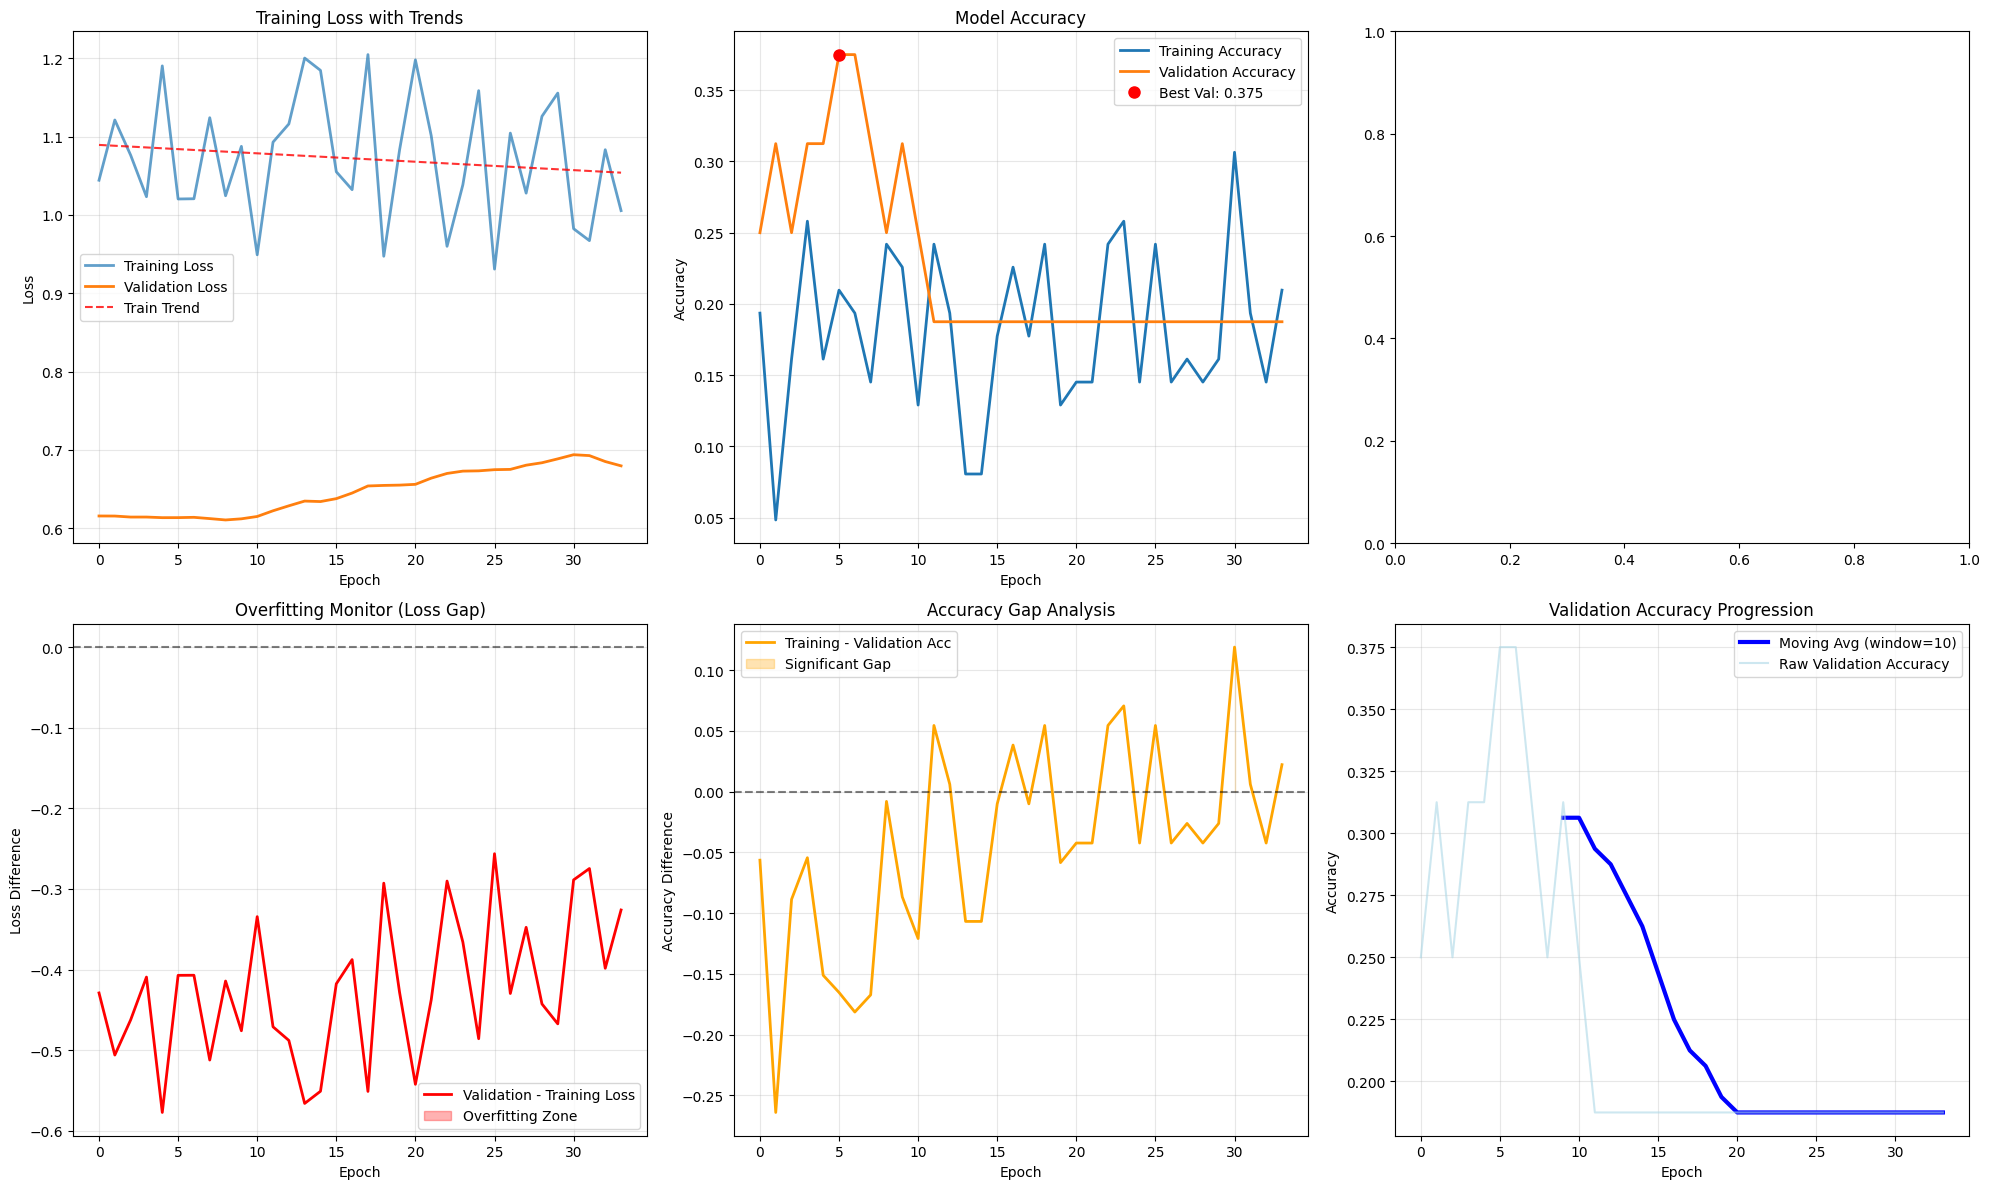


DETAILED MULTI-CLASS ANALYSIS:
Best validation accuracy: 0.3750 (epoch 6)
Final train/val accuracy: 0.2097/0.1875
Final overfitting gap: 0.0222
Random baseline: 20.0%
Improvement over random: 87.5%
PERFORMANCE: GOOD for multi-class complexity
OVERFITTING: Minimal - excellent generalization

COMPREHENSIVE MULTI-CLASS ANALYSIS:


Detailed per-class performance for 5 classes:
  before         : F1=0.333, P=0.500, R=0.250, N= 4 (LEARNED ✓)
  cool           : F1=0.000, P=0.000, R=0.000, N= 3 (COLLAPSED ✗)
  drink          : F1=0.000, P=0.000, R=0.000, N= 3 (COLLAPSED ✗)
  go             : F1=0.000, P=0.000, R=0.000, N= 3 (COLLAPSED ✗)
  thin           : F1=0.375, P=0.231, R=1.000, N= 3 (LEARNED ✓)

COMPREHENSIVE SUMMARY:
Learned classes: 2/5 (40.0%)
Partially learned: 0/5 (0.0%)
Collapsed classes: 3/5 (60.0%)
Effective learning ratio: 0.40 (40.0%)
F1 scores - Avg: 0.142, Min: 0.000, Max: 0.375
Best validation accuracy: 0.3750
Improvement over random (20.0%): 87.5%
OVERALL RESULT: MODERATE - Partial success, some collapse

IMPROVEMENT RECOMMENDATIONS:
1. Consider collecting more data per class (20+ videos)
2. Try different model architectures (CNN+LSTM, Transformer)
3. Experiment with different loss functions
4. Increase model capacity further

CLASS-BALANCED TRAINING RESULTS
Best Validation Accuracy: 0.3750 (Epoch

In [50]:
# @title 7: Run Class-Balanced Training (FIX CLASS COLLAPSE)
print("Starting CLASS-BALANCED ASL Recognition Training...")
print("PRIMARY MISSION: Fix class collapse and overfitting")
print("STRATEGY: Small model + Perfect balance + Strong regularization")
print("=" * 70)

# Clear memory and reset
tf.keras.backend.clear_session()
gc.collect()
set_seeds(SEED)

try:
    # Run class-balanced training
    results = train_model(config)

    if results and len(results) == 5:
        model, label_encoder, history, X_val, y_val = results

        if history and model and label_encoder:
            val_accuracies = history.history.get('val_accuracy', [])
            train_accuracies = history.history.get('accuracy', [])

            if val_accuracies and train_accuracies:
                best_val_acc = max(val_accuracies)
                best_epoch = np.argmax(val_accuracies) + 1
                final_val_acc = val_accuracies[-1]
                final_train_acc = train_accuracies[-1]
                overfitting_gap = final_train_acc - final_val_acc
                epochs_completed = len(history.history['loss'])

                print("\n" + "="*70)
                print("CLASS-BALANCED TRAINING RESULTS")
                print("="*70)
                print(f"Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")
                print(f"Final Train/Val: {final_train_acc:.4f}/{final_val_acc:.4f}")
                print(f"Overfitting Gap: {overfitting_gap:.4f}")
                print(f"Epochs Completed: {epochs_completed}/{config.num_epochs}")

                # Compare to previous results (from your notes)
                previous_best = 0.50  # Your 50% accuracy with class collapse
                print(f"\nComparison to Previous Results:")
                print(f"Previous (with class collapse): 50.0% accuracy, only 1 class learned")
                print(f"Current: {best_val_acc*100:.1f}% accuracy")

                # Detailed analysis
                if best_val_acc > 0.60:
                    print("STATUS: EXCELLENT - Major improvement!")
                elif best_val_acc > 0.45:
                    print("STATUS: GOOD - Competitive with previous results")
                elif best_val_acc > 0.33:
                    print("STATUS: LEARNING - Better than random, all classes learning")
                else:
                    print("STATUS: POOR - Need to investigate")

                # Overfitting analysis
                if overfitting_gap < 0.1:
                    print("OVERFITTING: MINIMAL - Excellent generalization")
                elif overfitting_gap < 0.2:
                    print("OVERFITTING: MODERATE - Acceptable")
                else:
                    print("OVERFITTING: HIGH - Need more regularization")

                # Check if class collapse is fixed
                try:
                    from sklearn.metrics import classification_report

                    y_pred = model.predict(X_val, verbose=0)
                    y_pred_classes = np.argmax(y_pred, axis=1)

                    report = classification_report(
                        y_val, y_pred_classes,
                        target_names=label_encoder.classes_,
                        output_dict=True,
                        zero_division=0
                    )

                    print(f"\nCLASS COLLAPSE ANALYSIS:")
                    learned_classes = 0
                    total_classes = len(label_encoder.classes_)

                    for class_name in label_encoder.classes_:
                        if class_name in report:
                            f1 = report[class_name]['f1-score']
                            precision = report[class_name]['precision']
                            recall = report[class_name]['recall']

                            if f1 > 0.1:  # Threshold for "learned"
                                learned_classes += 1
                                status = "LEARNED ✓"
                            else:
                                status = "COLLAPSED ✗"

                            print(f"  {class_name}: F1={f1:.3f}, P={precision:.3f}, R={recall:.3f} ({status})")

                    collapse_ratio = learned_classes / total_classes
                    print(f"\nCLASS LEARNING SUMMARY:")
                    print(f"Classes learned: {learned_classes}/{total_classes} ({collapse_ratio*100:.1f}%)")

                    if collapse_ratio >= 0.9:
                        print("RESULT: CLASS COLLAPSE FIXED! ✓✓✓")
                        print("All or nearly all classes are being learned")
                    elif collapse_ratio >= 0.7:
                        print("RESULT: MAJOR IMPROVEMENT ✓✓")
                        print("Most classes learning, minor collapse remains")
                    elif collapse_ratio >= 0.5:
                        print("RESULT: PARTIAL SUCCESS ✓")
                        print("Some improvement, but significant collapse remains")
                    else:
                        print("RESULT: CLASS COLLAPSE PERSISTS ✗")
                        print("Need stronger measures")

                except Exception as e:
                    print(f"Could not analyze class collapse: {e}")

                # Save model if results are good
                if best_val_acc > 0.25 or overfitting_gap < 0.3:
                    try:
                        model.save(f"/content/{config.model_name}_final.keras")
                        print(f"\nModel saved: {config.model_name}_final.keras")
                    except Exception as e:
                        print(f"Could not save model: {e}")

                # Next steps recommendations
                print(f"\nRECOMMENDATIONS:")
                if best_val_acc > 0.4 and overfitting_gap < 0.2:
                    print("1. Results look promising! Try adding more classes")
                    print("2. Experiment with longer sequences")
                    print("3. Consider ensemble methods")
                elif overfitting_gap > 0.3:
                    print("1. Increase dropout further (0.6-0.7)")
                    print("2. Add more L2 regularization")
                    print("3. Reduce model size even more")
                    print("4. Get more training data per class")
                else:
                    print("1. Check feature extraction quality")
                    print("2. Verify data balance is maintained")
                    print("3. Try different architectures (transformer?)")
                    print("4. Investigate class separability")

            else:
                print("ERROR: No training metrics recorded")
        else:
            print("ERROR: Training returned incomplete results")
    else:
        print("ERROR: Training failed completely")

except Exception as e:
    print(f"TRAINING ERROR: {e}")
    import traceback
    traceback.print_exc()

    print(f"\nTROUBLESHOOTING GUIDE:")
    print(f"1. Check if dataset path is correct")
    print(f"2. Verify videos are accessible and valid")
    print(f"3. Try reducing minimum videos per class")
    print(f"4. Check MediaPipe installation")
    print(f"5. Restart runtime if memory issues")

finally:
    # Clean up
    gc.collect()
    print(f"\n{'='*70}")
    print("Training attempt completed.")
    print("Check results above to see if class collapse was fixed!")
    print("If class collapse persists, we need to try even stronger measures.")